In [1]:
from tcrpeg.TCRpeg import TCRpeg
from tcrpeg.classification import classification
import pandas as pd
import numpy as np
import os
from tcrpeg.evaluate import evaluation
from tcrpeg.utils import plotting
from tcrpeg.word2vec import word2vec
import warnings
warnings.filterwarnings('ignore')

### Load TCRs; The 'TCRs_train.csv' is an example data that contains 100k TCRs randomly sampled from the universal TCR pool constructed using the 743 individual TCR repertoires from Emerson et al.

In [2]:
tcrs_train = pd.read_csv('tcrpeg/data/TCRs_train.csv',compression='gzip')['seq'].values
tcrs_train[:3]

array(['CASSLTFGNTIYF', 'CATGFPNYGYTF', 'CASSLGSGDYNEQFF'], dtype=object)

### Train a word2vec model to obtain the numerial embeddings for each amino acid. We also provide our pre-trained AA embeddings: 'tcrpeg/data/embedding_32.txt'.

In [3]:
aa_emb = word2vec(path=tcrs_train,epochs=1,batch_size=10,device='cuda:0',lr=0.0001,window_size=2,record_path='tcrpeg/data/your_aa_emb.txt')

100%|██████████| 603691/603691 [01:23<00:00, 7215.61it/s]

Loss at epo 1: 10.220311711741523


### Define and infer TCRpeg model

In [5]:
#create the TCRpeg class
model = TCRpeg(hidden_size=64,num_layers = 3,load_data=True,embedding_path='tcrpeg/data/embedding_32.txt',path_train=tcrs_train)
#create the TCRpeg model. 
model.create_model()
#begin inferring
model.train_tcrpeg(epochs=3,batch_size=64,lr=1e-3)

#model.save('path_to_save.pth') #save the TCRpeg model
#model.create_model(load=True,path='path_to_save.pth') #load the model

Have loaded the data, total training seqs : 100000
begin the training process
begin epoch : 1


100%|██████████| 1562/1562 [00:03<00:00, 440.27it/s]


nll_loss: 21.862992496710277
begin epoch : 2


100%|██████████| 1562/1562 [00:03<00:00, 439.95it/s]


nll_loss: 19.744967945406593
begin epoch : 3


100%|██████████| 1562/1562 [00:03<00:00, 438.74it/s]

nll_loss: 19.547791816818883
Done training


### Load the plotting module and evaluation class

In [6]:
Plot = plotting()
eva = evaluation(model=model) # used for evaluate the probability inference

In [7]:
#load the test data, also randomly sampled from the test set of the universal TCR pool
test_data = pd.read_csv('tcrpeg/data/pdf_test.csv',compression='gzip')
data = {'seq':test_data['seq'].values,'count':test_data['count'].values} 
#evaluate the inference performance
r,p_data,p_infer = eva.eva_prob(path=data)
print('The Pearson\'s correlation coefficient is: ',r)

100%|██████████| 21/21 [00:00<00:00, 122.79it/s]


Pearson correlation coefficient are : 0.8773
The Pearson's correlation coefficient is:  0.877349958142228


### Make the inference plot

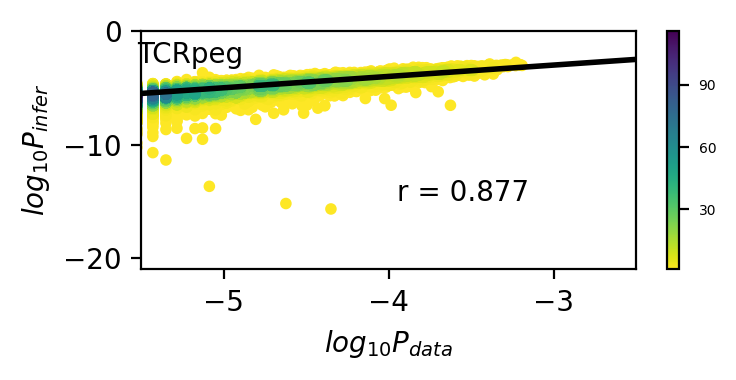

In [8]:
Plot.plot_prob(p_data,p_infer)

### Get the encodings of TCRs

In [10]:
seq_embs = model.get_embedding(tcrs_train[:100])
seq_embs[0,:][:10]

array([ 0.72739947, -0.03748147,  0.8001249 ,  0.16962576, -0.7739323 ,
        0.785437  ,  0.90924907,  0.0800257 ,  0.7261374 ,  0.8008027 ],
      dtype=float32)

### Generate TCR sequences

In [11]:
gens = model.generate_tcrpeg(num_to_gen=10000,batch_size=1000) #generate TCRs batch by batch
gens[:3]

100%|██████████| 10/10 [00:02<00:00,  3.82it/s]


['CASRPGGSNTGEQFF', 'CASMSGGLSSYNEQFF', 'CASSPDRERYGYTF']

### Plot the distributions of length and each amino acids

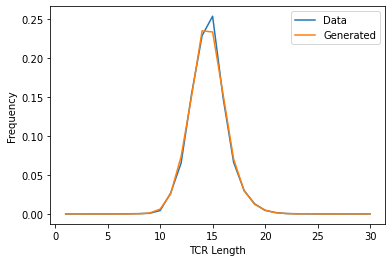

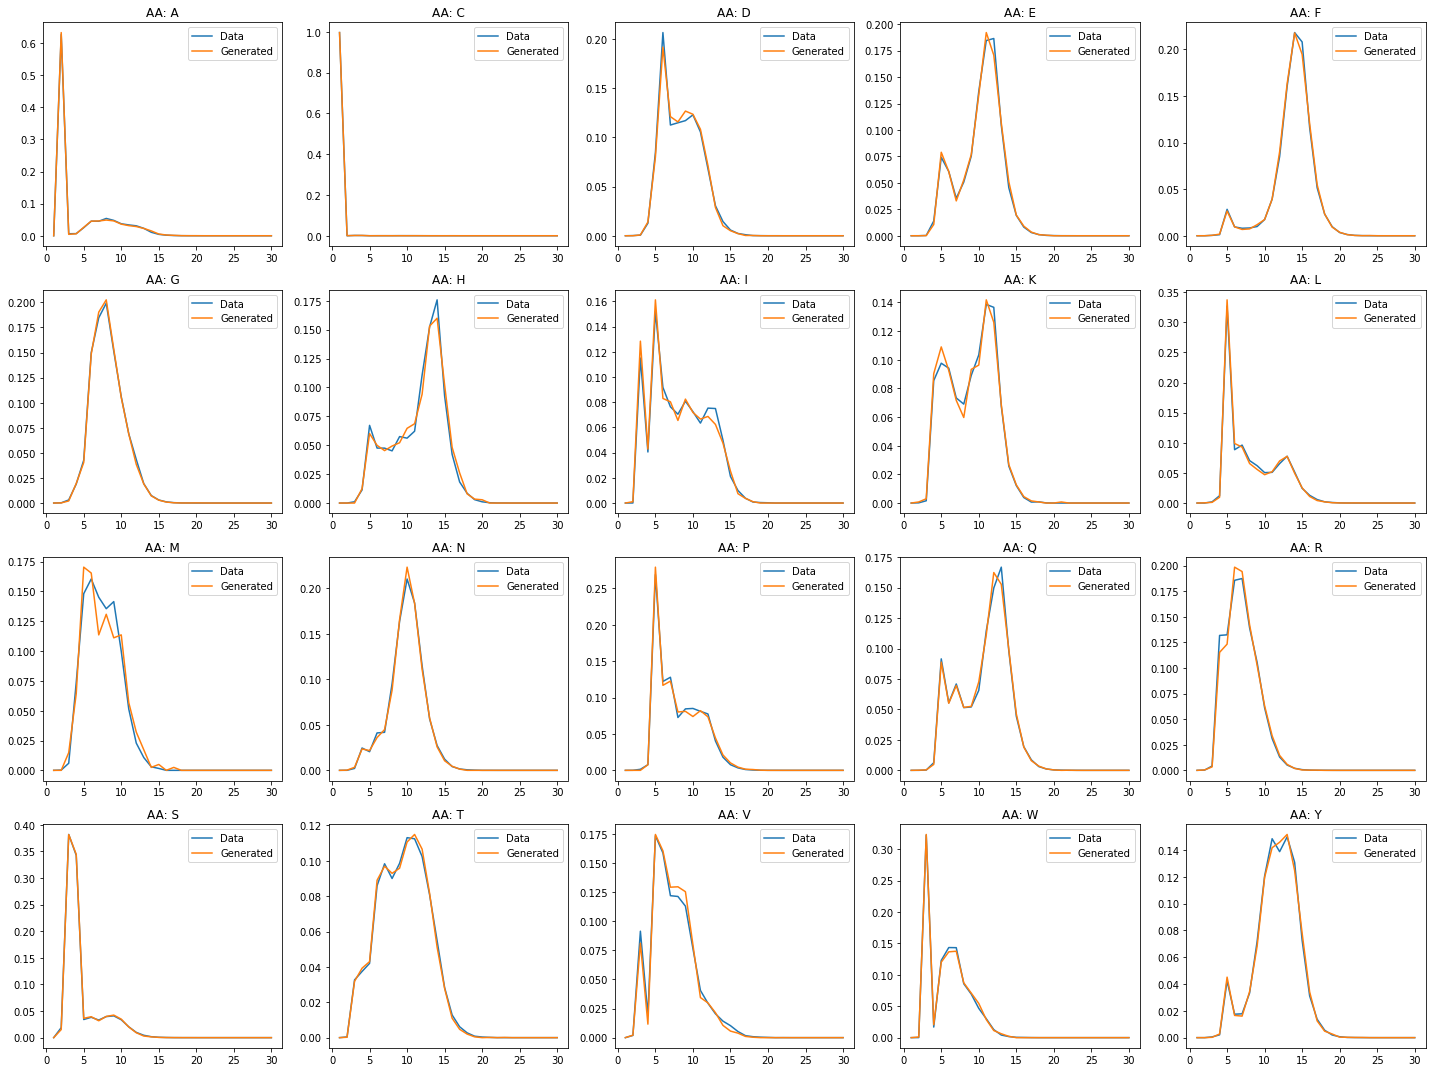

In [12]:
Plot.Length_Dis(tcrs_train,gens)
Plot.AAs_Dis(tcrs_train,gens)

### Generate TCR sequences along with corresponding V and J genes (TCRpeg_vj model)

In [13]:
#load tcrs along with v and j genes
tcrvj_train = pd.read_csv('tcrpeg/data/TCRs_train.csv',compression='gzip')
tcrvj_train[:3]

,seq,v,j
0,CASSLTFGNTIYF,TRBV5-8,TRBJ1-3
1,CATGFPNYGYTF,TRBV28,TRBJ1-2
2,CASSLGSGDYNEQFF,TRBV7-6,TRBJ2-1


In [14]:
# Define and infer TCRpeg_vj 
vj_data = [[tcrvj_train.iloc[i][0],tcrvj_train.iloc[i][1],tcrvj_train.iloc[i][2]] for i in range(len(tcrvj_train))] #vj_data should be in format [[seq1,v1,j1],[seq2,v2,j2]...]
model_vj  =TCRpeg(hidden_size=64,num_layers = 3,load_data=True,embedding_path='tcrpeg/data/embedding_32.txt',path_train=vj_data,vj=True)
model_vj.create_model(vj=True)
model_vj.train_tcrpeg_vj(epochs=1,batch_size=16,lr=1e-3)

Have loaded the data, total training seqs : 100000
begin the training process
begin epoch : 1


100%|██████████| 6250/6250 [00:14<00:00, 433.39it/s]

nll_loss: 20.68206773880005
v_loss: 3.221218884334564
j_loss: 0.08122862688388675
Done training


In [15]:
#Generate seqs along with v and j genes
gens_vj = model_vj.generate_tcrpeg_vj(10000,1000)
[gens_vj[i][:3] for i in range(3)]

100%|██████████| 10/10 [00:00<00:00, 342.69it/s]


[['CASSRTAGKHSPLHF', 'CASMRGQGARNIPANVLTF', 'CASSLLRGRPPQHF'],
 ['TRBV19', 'TRBV6-1', 'TRBV27'],
 ['TRBJ1-6', 'TRBJ2-6', 'TRBJ1-5']]

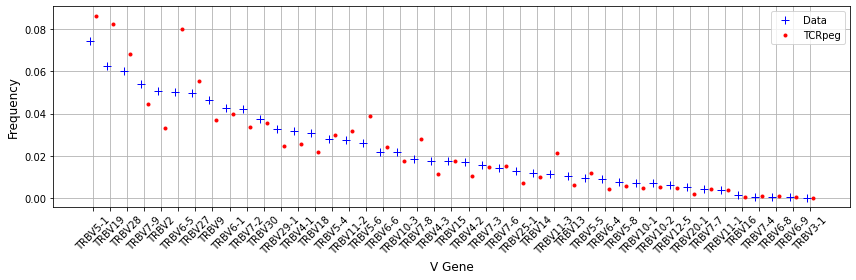

In [16]:
Plot.V_Dis(tcrvj_train['v'].values, gens_vj[1])

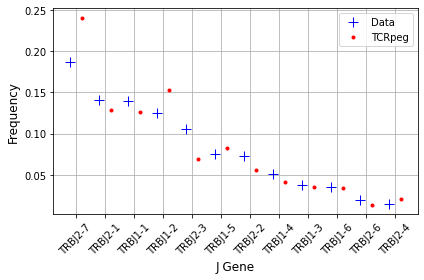

In [17]:
Plot.J_Dis(tcrvj_train['j'].values, gens_vj[2])

### Use TCRpeg-c for classification tasks

In [18]:
#load some data; This dataset is a subset of the caTCR dataset; total seqs: 8000;
data = pd.read_csv('tcrpeg/data/classification.csv')
x,y = list(data['seq']),list(data['label'])
#half of seqs are assigned as training/test data
x_train,y_train,x_test,y_test = x[:4000],y[:4000],x[4000:],y[4000:]

In [19]:
tcrpeg_c = classification(tcrpeg=model,embedding_size=64*3) #tcrpeg-c needs a pre-trained tcrpeg for providing emebddings
tcrpeg_c.train(x_train=x_train,y_train=y_train,epochs=3,batch_size=8,lr=1e-3,val_split=0.2)
auc,aup,y_pres,y_trues = tcrpeg_c.evaluate(x_test=x_test,y_test=y_test,batch_size=100)

begin epoch : 1


100%|██████████| 400/400 [00:00<00:00, 696.96it/s]


mean loss : 0.6822410035133362


100%|██████████| 100/100 [00:00<00:00, 1376.85it/s]


evaluation, avg_loss and auc is :1.188216252848506 and 0.591
begin epoch : 2


100%|██████████| 400/400 [00:00<00:00, 811.30it/s]


mean loss : 0.6785198716819286


100%|██████████| 100/100 [00:00<00:00, 1379.52it/s]


evaluation, avg_loss and auc is :0.6782877868413926 and 0.592
The learning rate is reduced
begin epoch : 3


100%|██████████| 400/400 [00:00<00:00, 816.60it/s]


mean loss : 0.6696590098738671


100%|██████████| 100/100 [00:00<00:00, 1387.44it/s]


evaluation, avg_loss and auc is :0.6721183609962463 and 0.62
The learning rate is reduced
end training


100%|██████████| 40/40 [00:00<00:00, 1068.87it/s]


evaluation, avg_loss and auc is :0.667896443605423 and 0.633


In [13]:
##Save and load
#tcrpeg_c.save('path_to_save.pth') #save
#tcrpeg_c.load_model('path_to_save'.pth) #load

In [20]:
print('The AUC value is: ',auc)

The AUC value is:  0.633
